### Objective: To redo calculations of descriptors on antibodies with Heparin RTT using Denovo Structure Predictions. 
The goal is compare denovov calcs with calcs based on the EM structure. 

```python
import pandas as pd
from ImmuneBuilder import ABodyBuilder2
from pathlib import Path
from tqdm.notebook import tqdm

DATAPATH  = "/Users/ChristopherRivera/Documents/DataResults/MPK190" 
data_path = Path(DATAPATH)

def predict_antibody_structures(sequences, output_dir=None):
    """Given a dataframe with sequences, use ABodyBuilder2 model to predict sequences
    Args: 
        sequence(pd.DataFrame|str|Path): data frame with columns 'Name', 'VH', 'VL'
        output_dir(path|Str): location to save models. 
    Returns: 
        None
    """

    predictor = ABodyBuilder2()
    if isinstance(sequences, str) or isinstance(sequences, Path):
        sequences = pd.read_csv(sequences)
    elif isinstance(sequences, pd.DataFrame): 
        pass
    else:
        print('Not antibodies')

    sequences= sequences.dropna()
    errors=[]

    iterator = zip(sequences['Name'], sequences['VH'], sequences['VL'])
    n = len(sequences)
    for name, hc, lc in tqdm(iterator, total=n):
        sequences = {'H': hc,'L': lc}
        try:
            antibody = predictor.predict(sequences)

            if output_dir: 
                output_file = output_dir/f'{name}.pdb'
                antibody.save(str(output_file))
        except AssertionError:
            
            errors.append(name)
    return errors


# load the data and reformat
metadata_df=pd.read_parquet(data_path/'MPK190-v13-metadata.pq')
mutations_df = (metadata_df[['HC FV', 'LC FV']].copy()
                .rename({'HC FV': 'VH', 'LC FV': 'VL'}, axis =1)
                .assign(Name = metadata_df.index.str.replace('/','-'))
                )             

# output path
output_path = data_path/'predicted_pdbs_for_HeparinRTT'
if not output_path.exists(): 
    output_path.mkdir()

errors = predict_antibody_structures(mutations_df, output_dir=output_path)


```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from shutil import copy
import matplotlib.pyplot as plt
import nglview as nv
from Bio.SeqUtils import seq3
from tqdm.notebook import tqdm
from pdbfixer import PDBFixer
from openmm.app import PDBFile
import numpy as np
import plotly.express as px
from developability.utils import ls, plot_correlogram
from developability.pipeline import run_processing_pipeline
from developability.pdb_tools import extract_fv_from_pdb, extract_sequence_from_pdb

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
%config InlineBackend.figure_format='retina'

In [2]:
DATAPATH  = "/Users/ChristopherRivera/Documents/DataResults/MPK190" 
data_path = Path(DATAPATH)

metadata = data_path/'MPK190-v13-metadata.pq'
metadata_df= pd.read_parquet(metadata)



In [3]:
descriptors = []
pdb_path = data_path/'predicted_pdbs_for_HeparinRTT'
descriptors_fname = data_path/'MPK190_descriptors_V13_heparin_column_DeNovo.pq'
pdbs = [f for f in ls(pdb_path) if f.name.endswith('.pdb')]

if not descriptors_fname.exists():

    for pdb in tqdm(pdbs, total = len(pdbs)):
        
        name = pdb.name.split('.')[0]
        out_path = pdb_path/ f'{name}_output'
        
        descriptors.append(run_processing_pipeline(input_pdb=pdb, output_path=out_path))

        descriptors_df = pd.concat(descriptors)
    descriptors_df.index = [pdb.name.split('.')[0] for pdb in pdbs]
    descriptors_df.to_parquet(descriptors_fname)
else: 
    descriptors_df = pd.read_parquet(descriptors_fname)

descriptors_df.head()

,HCDR1_APBS_pos,HCDR1_APBS_neg,HCDR1_APBS_net,HCDR2_APBS_pos,HCDR2_APBS_neg,HCDR2_APBS_net,HCDR3_APBS_pos,HCDR3_APBS_neg,HCDR3_APBS_net,HFR1_APBS_pos,HFR1_APBS_neg,HFR1_APBS_net,HFR2_APBS_pos,HFR2_APBS_neg,HFR2_APBS_net,HFR3_APBS_pos,HFR3_APBS_neg,HFR3_APBS_net,HFR4_APBS_pos,HFR4_APBS_neg,HFR4_APBS_net,LCDR1_APBS_pos,LCDR1_APBS_neg,LCDR1_APBS_net,LCDR2_APBS_pos,LCDR2_APBS_neg,LCDR2_APBS_net,LCDR3_APBS_pos,LCDR3_APBS_neg,LCDR3_APBS_net,LFR1_APBS_pos,LFR1_APBS_neg,LFR1_APBS_net,LFR2_APBS_pos,LFR2_APBS_neg,LFR2_APBS_net,LFR3_APBS_pos,LFR3_APBS_neg,LFR3_APBS_net,LFR4_APBS_pos,LFR4_APBS_neg,LFR4_APBS_net,HCDR_APBS_pos,HCDR_APBS_neg,HCDR_APBS_net,LCDR_APBS_pos,LCDR_APBS_neg,LCDR_APBS_net,HFR_APBS_pos,HFR_APBS_neg,HFR_APBS_net,LFR_APBS_pos,LFR_APBS_neg,LFR_APBS_net,HC_APBS_pos,HC_APBS_neg,HC_APBS_net,LC_APBS_pos,LC_APBS_neg,LC_APBS_net,TOTAL_CDR_APBS_pos,TOTAL_CDR_APBS_neg,TOTAL_CDR_APBS_net,TOTAL_FR_APBS_pos,TOTAL_FR_APBS_neg,TOTAL_FR_APBS_net,TOTAL_APBS_pos,TOTAL_APBS_neg,TOTAL_APBS_net
VIRMAB-ML-M190-R2-039,592.990159,-18.629960,574.360199,9664.069276,0.000000,9664.069276,1363.991387,-1797.590481,-433.599094,14917.288371,-322.223343,14595.065027,3810.916675,-29.344976,3781.571700,14008.259104,-17.322289,13990.936815,2467.285220,-114.751787,2352.533433,5322.747524,-334.080398,4988.667125,1904.435272,-70.895131,1833.540141,6547.019922,0.000000,6547.019922,9436.812786,-357.348621,9079.464166,3301.424938,-45.456650,3255.968288,4257.857450,-3047.594318,1210.263132,290.049554,-1460.767370,-1170.717817,11621.050822,-1816.220441,9804.830381,13774.202717,-404.975529,13369.227188,35203.749370,-483.642395,34720.106975,17286.144727,-4911.166959,12374.977768,46824.800192,-2299.862836,44524.937356,31060.347444,-5316.142488,25744.204956,25395.253539,-2221.195971,23174.057568,52489.894097,-5394.809354,47095.084743,77885.147636,-7616.005325,70269.142311
VIRMAB-ML-M190-R2-038,1014.743671,0.000000,1014.743671,8211.944213,0.000000,8211.944213,1101.056176,-1050.045931,51.010245,11625.393354,-476.201386,11149.191968,2744.916714,-109.546900,2635.369813,11191.532655,-26.968578,11164.564076,2447.537668,-139.229233,2308.308435,2138.641950,-500.404282,1638.237668,2562.932660,0.000000,2562.932660,4721.748956,0.000000,4721.748956,7529.132400,-564.022107,6965.110293,2077.647608,-309.580959,1768.066649,3482.442126,-3293.452422,188.989704,319.659053,-1768.514327,-1448.855274,10327.744060,-1050.045931,9277.698129,9423.323567,-500.404282,8922.919285,28009.380390,-751.946098,27257.434292,13408.881187,-5935.569815,7473.311372,38337.124450,-1801.992029,36535.132421,22832.204753,-6435.974097,16396.230656,19751.067626,-1550.450213,18200.617413,41418.261577,-6687.515913,34730.745664,61169.329204,-8237.966126,52931.363078
VIRMAB-ML-M190-R2-006,837.701183,0.000000,837.701183,6763.571347,-24.284907,6739.286440,599.803016,-2121.248587,-1521.445570,11277.754035,-483.835694,10793.918341,1322.349739,-586.210654,736.139085,11037.990802,-67.351677,10970.639125,1969.127021,-485.868013,1483.259007,2817.258019,-826.312316,1990.945702,9.038714,-3059.909290,-3050.870576,5315.218131,-51.685635,5263.532496,3860.895892,-1008.950975,2851.944917,1766.384444,-533.989181,1232.395264,1433.456276,-7058.839840,-5625.383565,0.000000,-2590.949648,-2590.949648,8201.075547,-2145.533494,6055.542053,8141.514863,-3937.907241,4203.607622,25607.221596,-1623.266038,23983.955558,7060.736612,-11192.729644,-4131.993032,33808.297142,-3768.799532,30039.497610,15202.251475,-15130.636885,71.614590,16342.590410,-6083.440735,10259.149675,32667.958208,-12815.995682,19851.962525,49010.548618,-18899.436417,30111.112200
VIRMAB-ML-M190-R2-028,581.912376,-125.982004,455.930372,5603.872785,-26.103024,5577.769762,1260.483437,-1654.066177,-393.582740,14135.530273,-303.632677,13831.897596,3594.370134,-38.569050,3555.801084,11728.391612,-38.615755,11689.775857,2481.014995,-215.802753,2265.212241,1328.991771,-1024.837108,304.154663,2063.686075,-41.910195,2021.775880,3188.860615,-72.570746,3116.289868,8420.259660,-528.034832

In [4]:
descriptors_df=descriptors_df.sort_index()
metadata_df=metadata_df.sort_index()



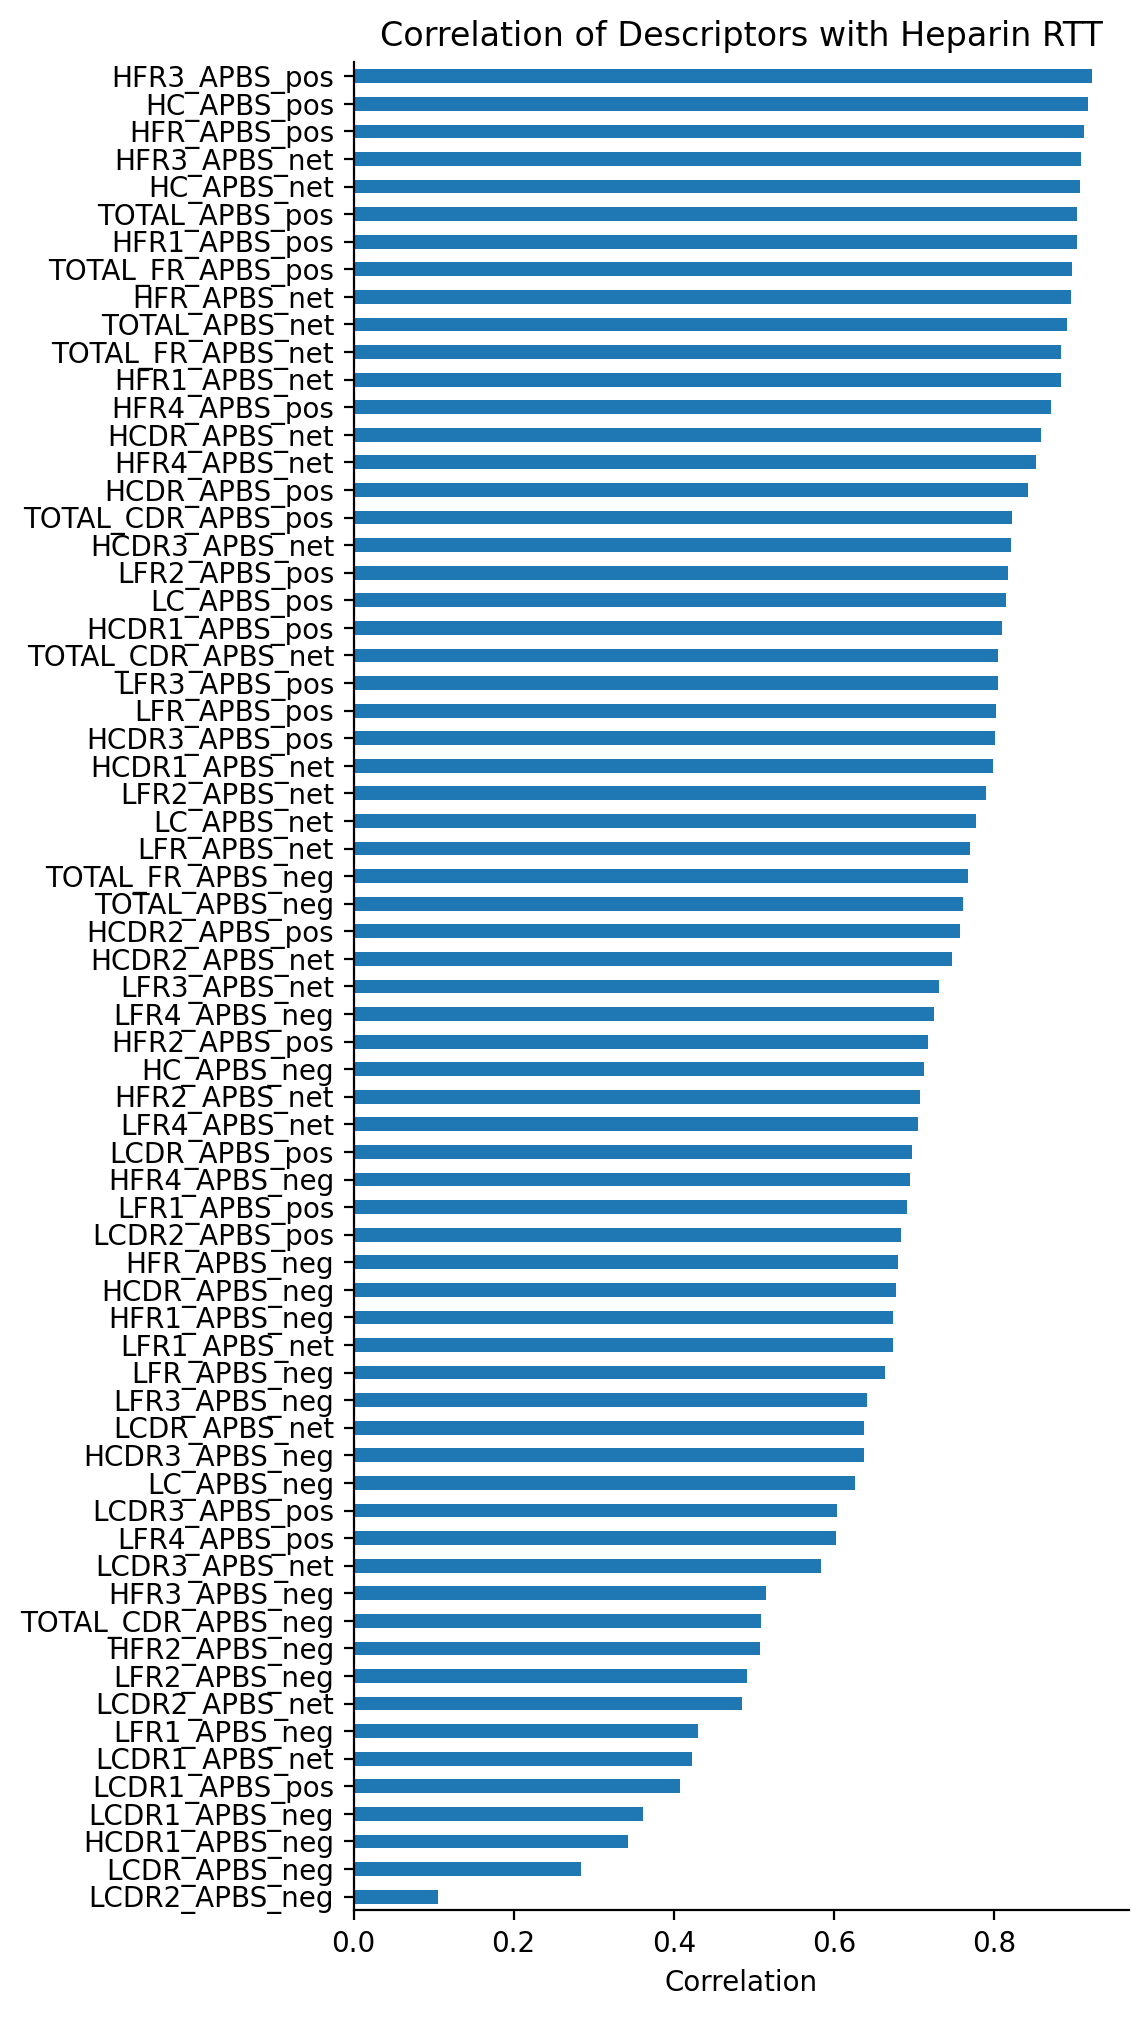

In [13]:
mean_zeros = (descriptors_df==0).mean()
descriptors_df = descriptors_df[mean_zeros.index[mean_zeros<0.55]]

heparin = metadata_df['Hep RTT'].astype(float)
heparin_corr= descriptors_df.corrwith(heparin).sort_values()

ax = heparin_corr.plot(kind = 'barh', figsize = (5,12))
ax.set(xlabel = 'Correlation', title='Correlation of Descriptors with Heparin RTT')
sns.despine()


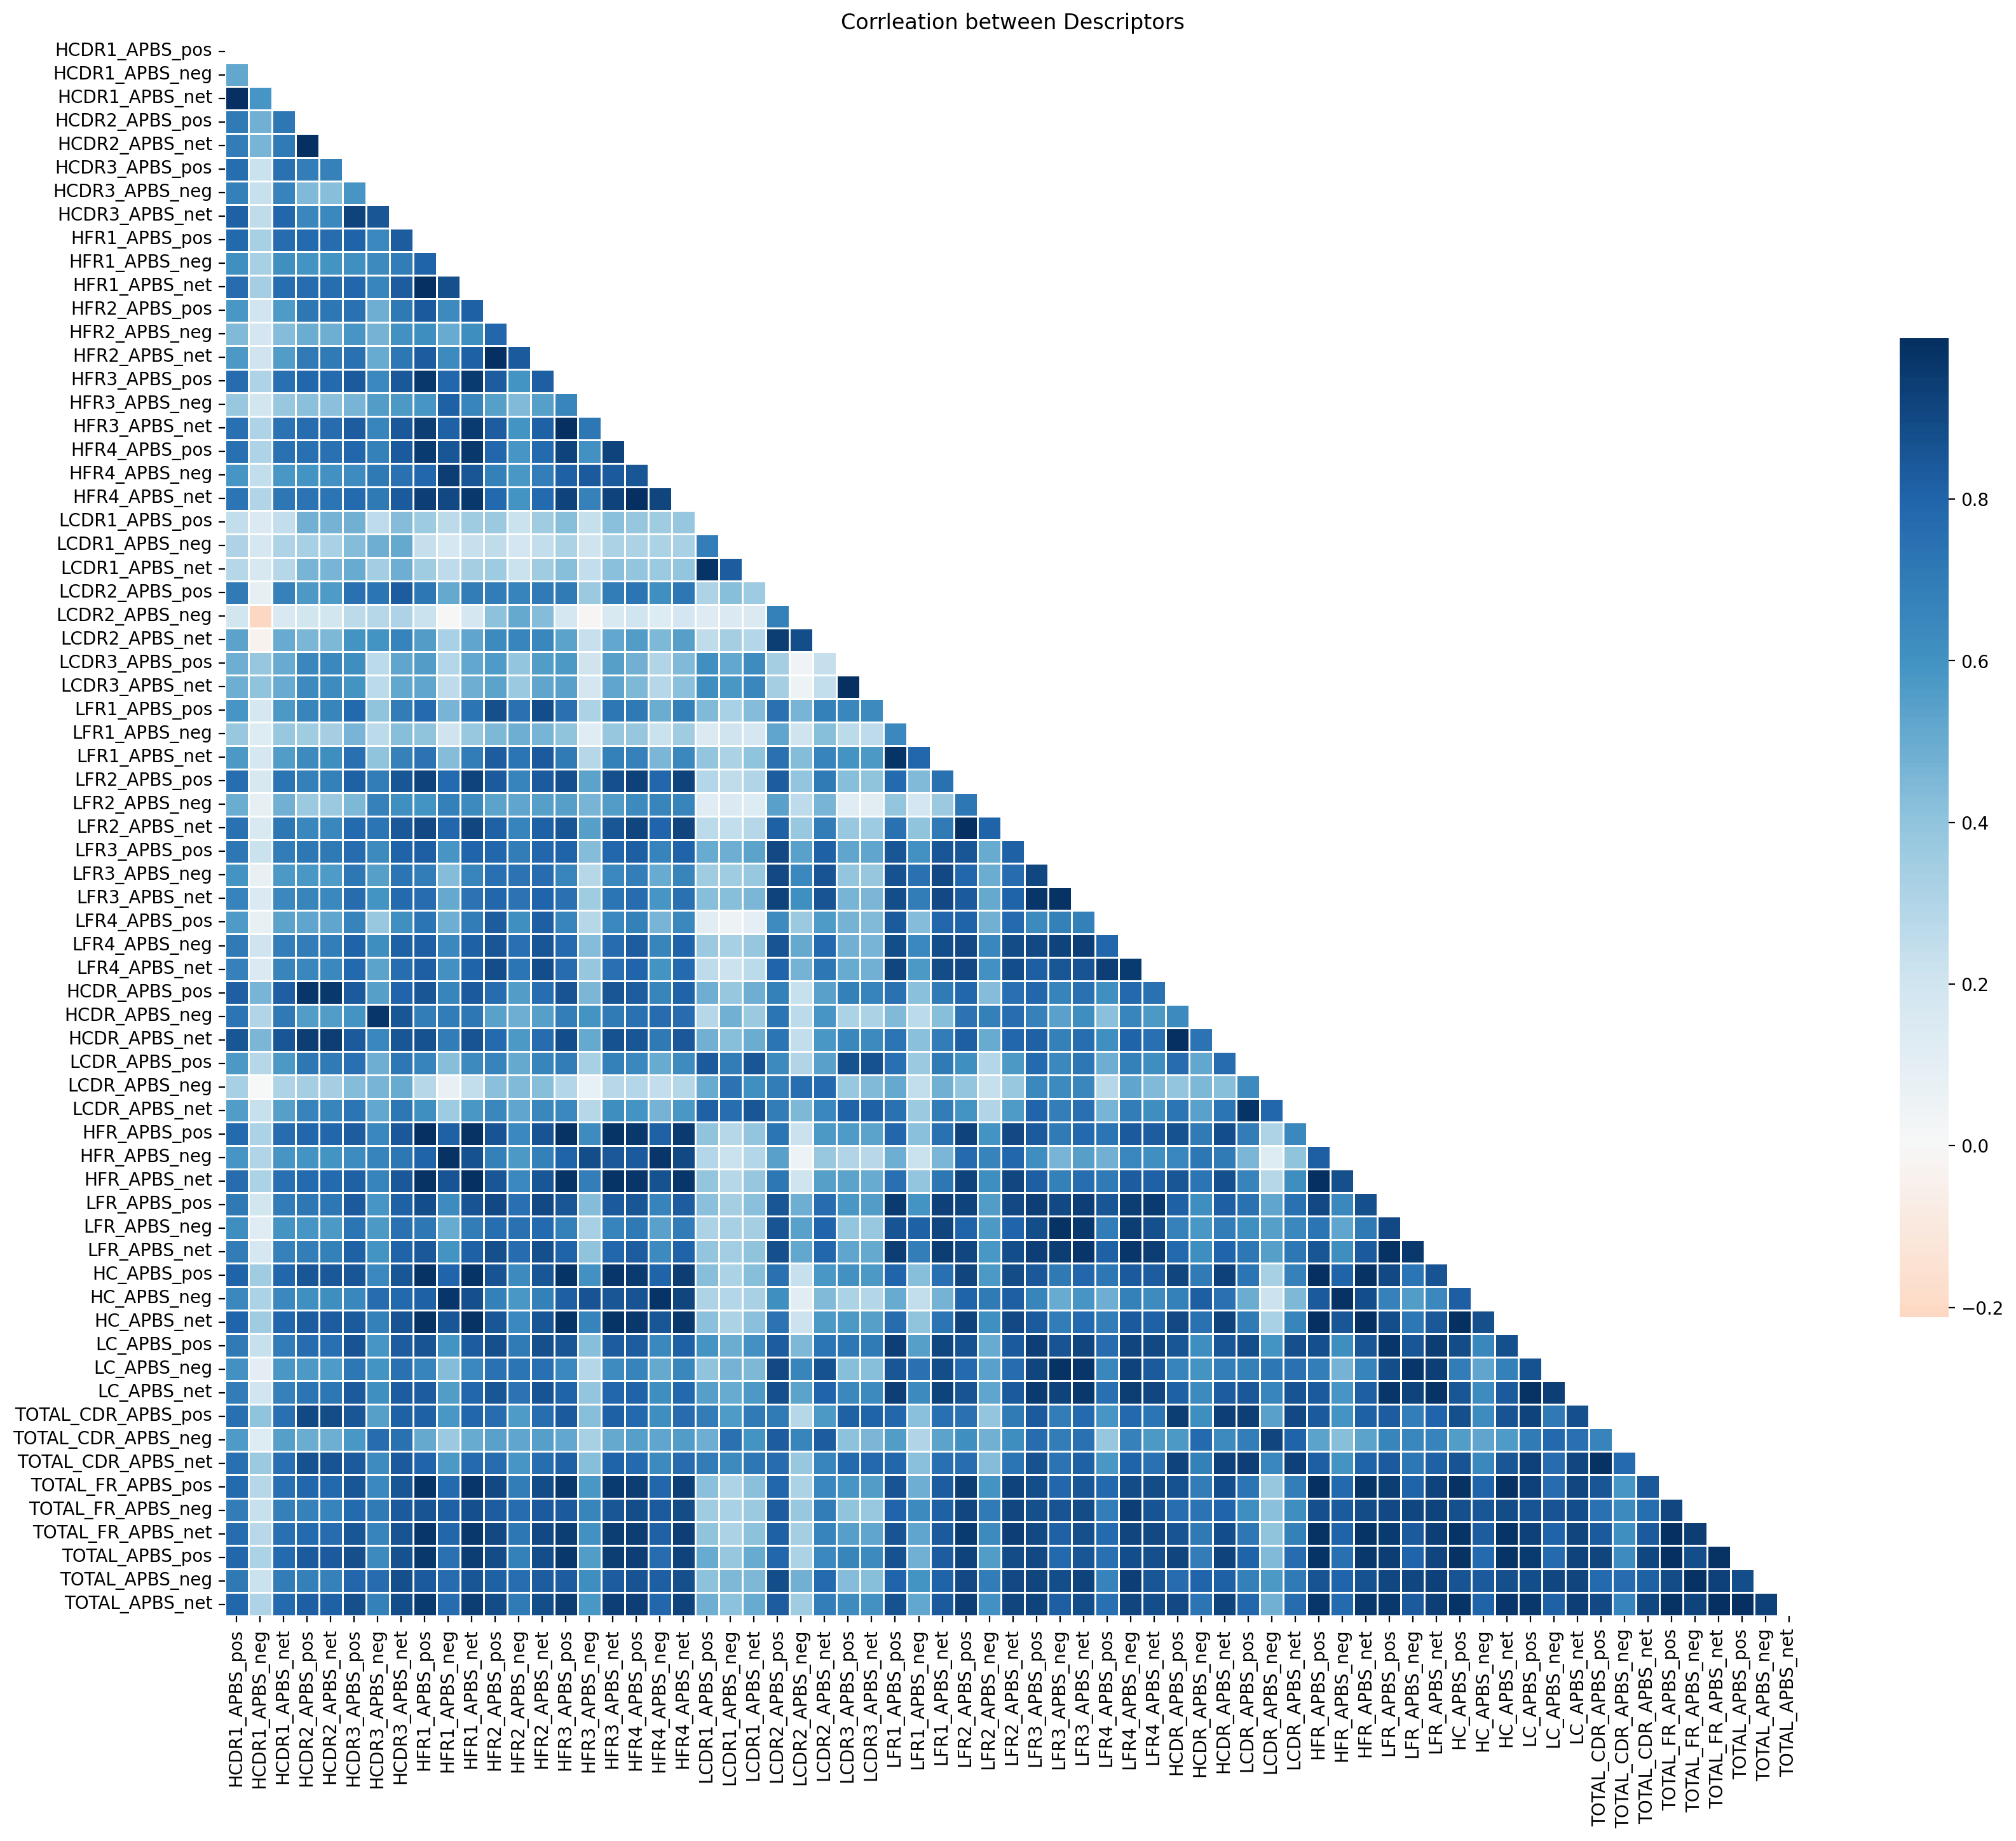

In [14]:
plot_correlogram(descriptors_df, title='Corrleation between Descriptors', figsize = (20,20))

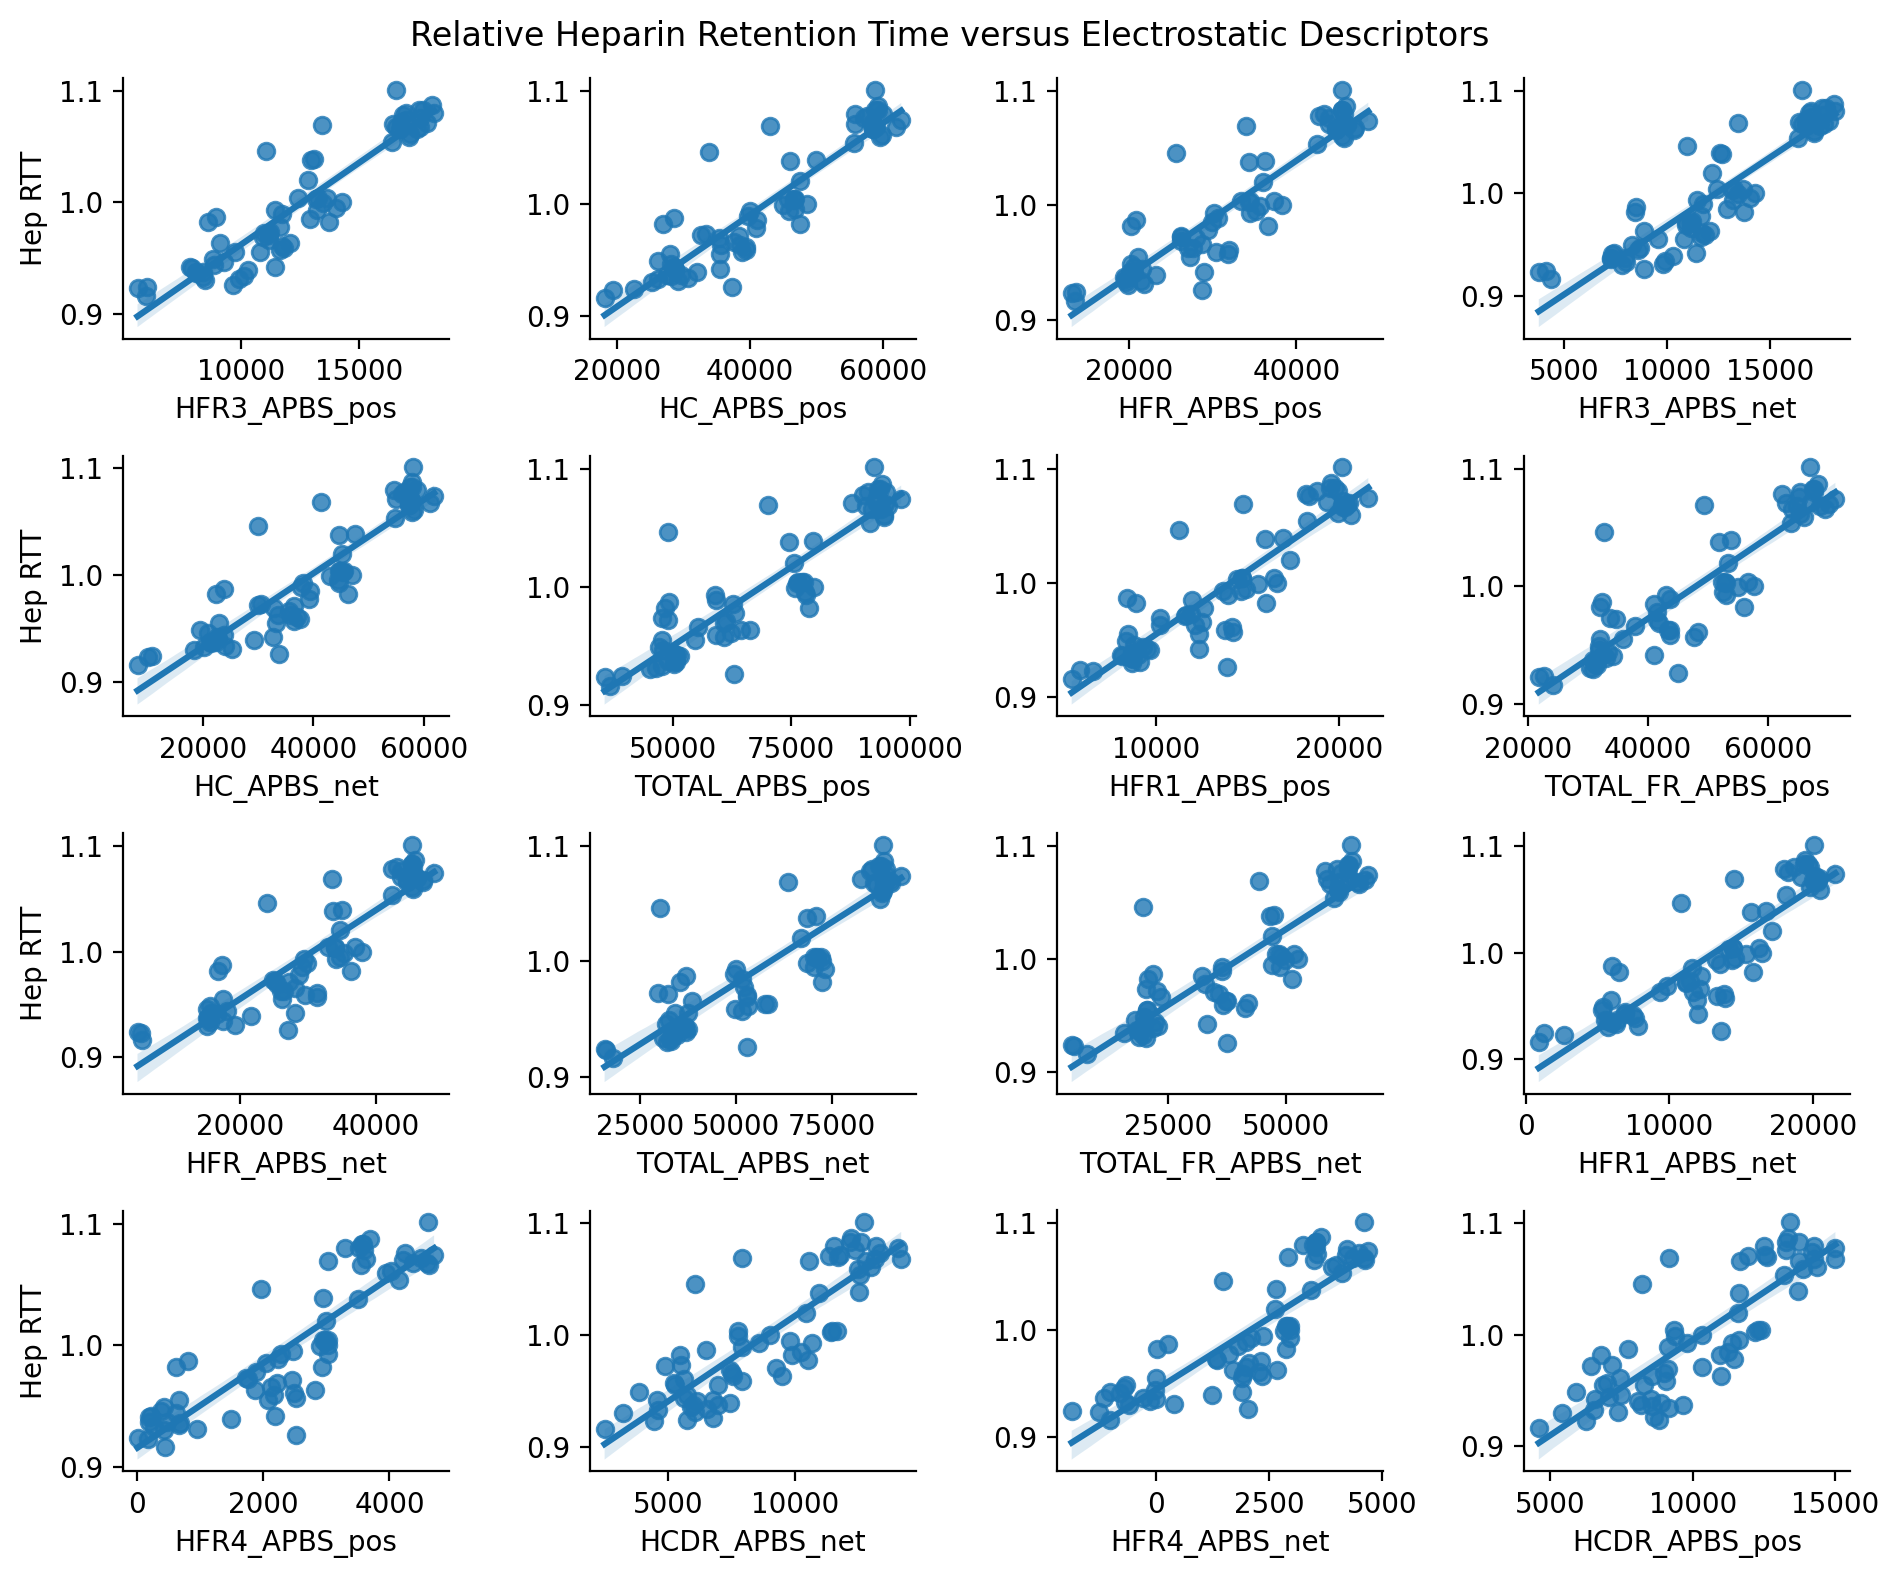

In [7]:
n = 4
height = 2
width = height*1.2

fig, axes = plt.subplots(n,n,figsize =(n*width, n*height))
axes = np.ravel(axes)

cols = heparin_corr.sort_values(ascending = False).index
for i, ax in enumerate(axes): 
    sns.regplot(x = descriptors_df[cols[i]],y = heparin ,ax = ax)
    if i%n==0: 
        ax.set(ylabel = 'Hep RTT', xlabel = cols[i])
    else: 
        ax.set(xlabel = cols[i], ylabel = '')

sns.despine()
fig.suptitle('Relative Heparin Retention Time versus Electrostatic Descriptors')
plt.tight_layout()


In [8]:
print(heparin_corr.sort_values(ascending = False).head(5))

HFR3_APBS_pos    0.922081
HC_APBS_pos      0.917921
HFR_APBS_pos     0.912946
HFR3_APBS_net    0.908444
HC_APBS_net      0.906887
dtype: float64


### Load the previous descriptors and plot the results against each other. 

In [9]:
solved_descriptors_df = (pd.read_parquet(data_path/'MPK190_descriptors_V13_heparin_column.pq')
                         .sort_index()
                         [descriptors_df.columns]
                         )

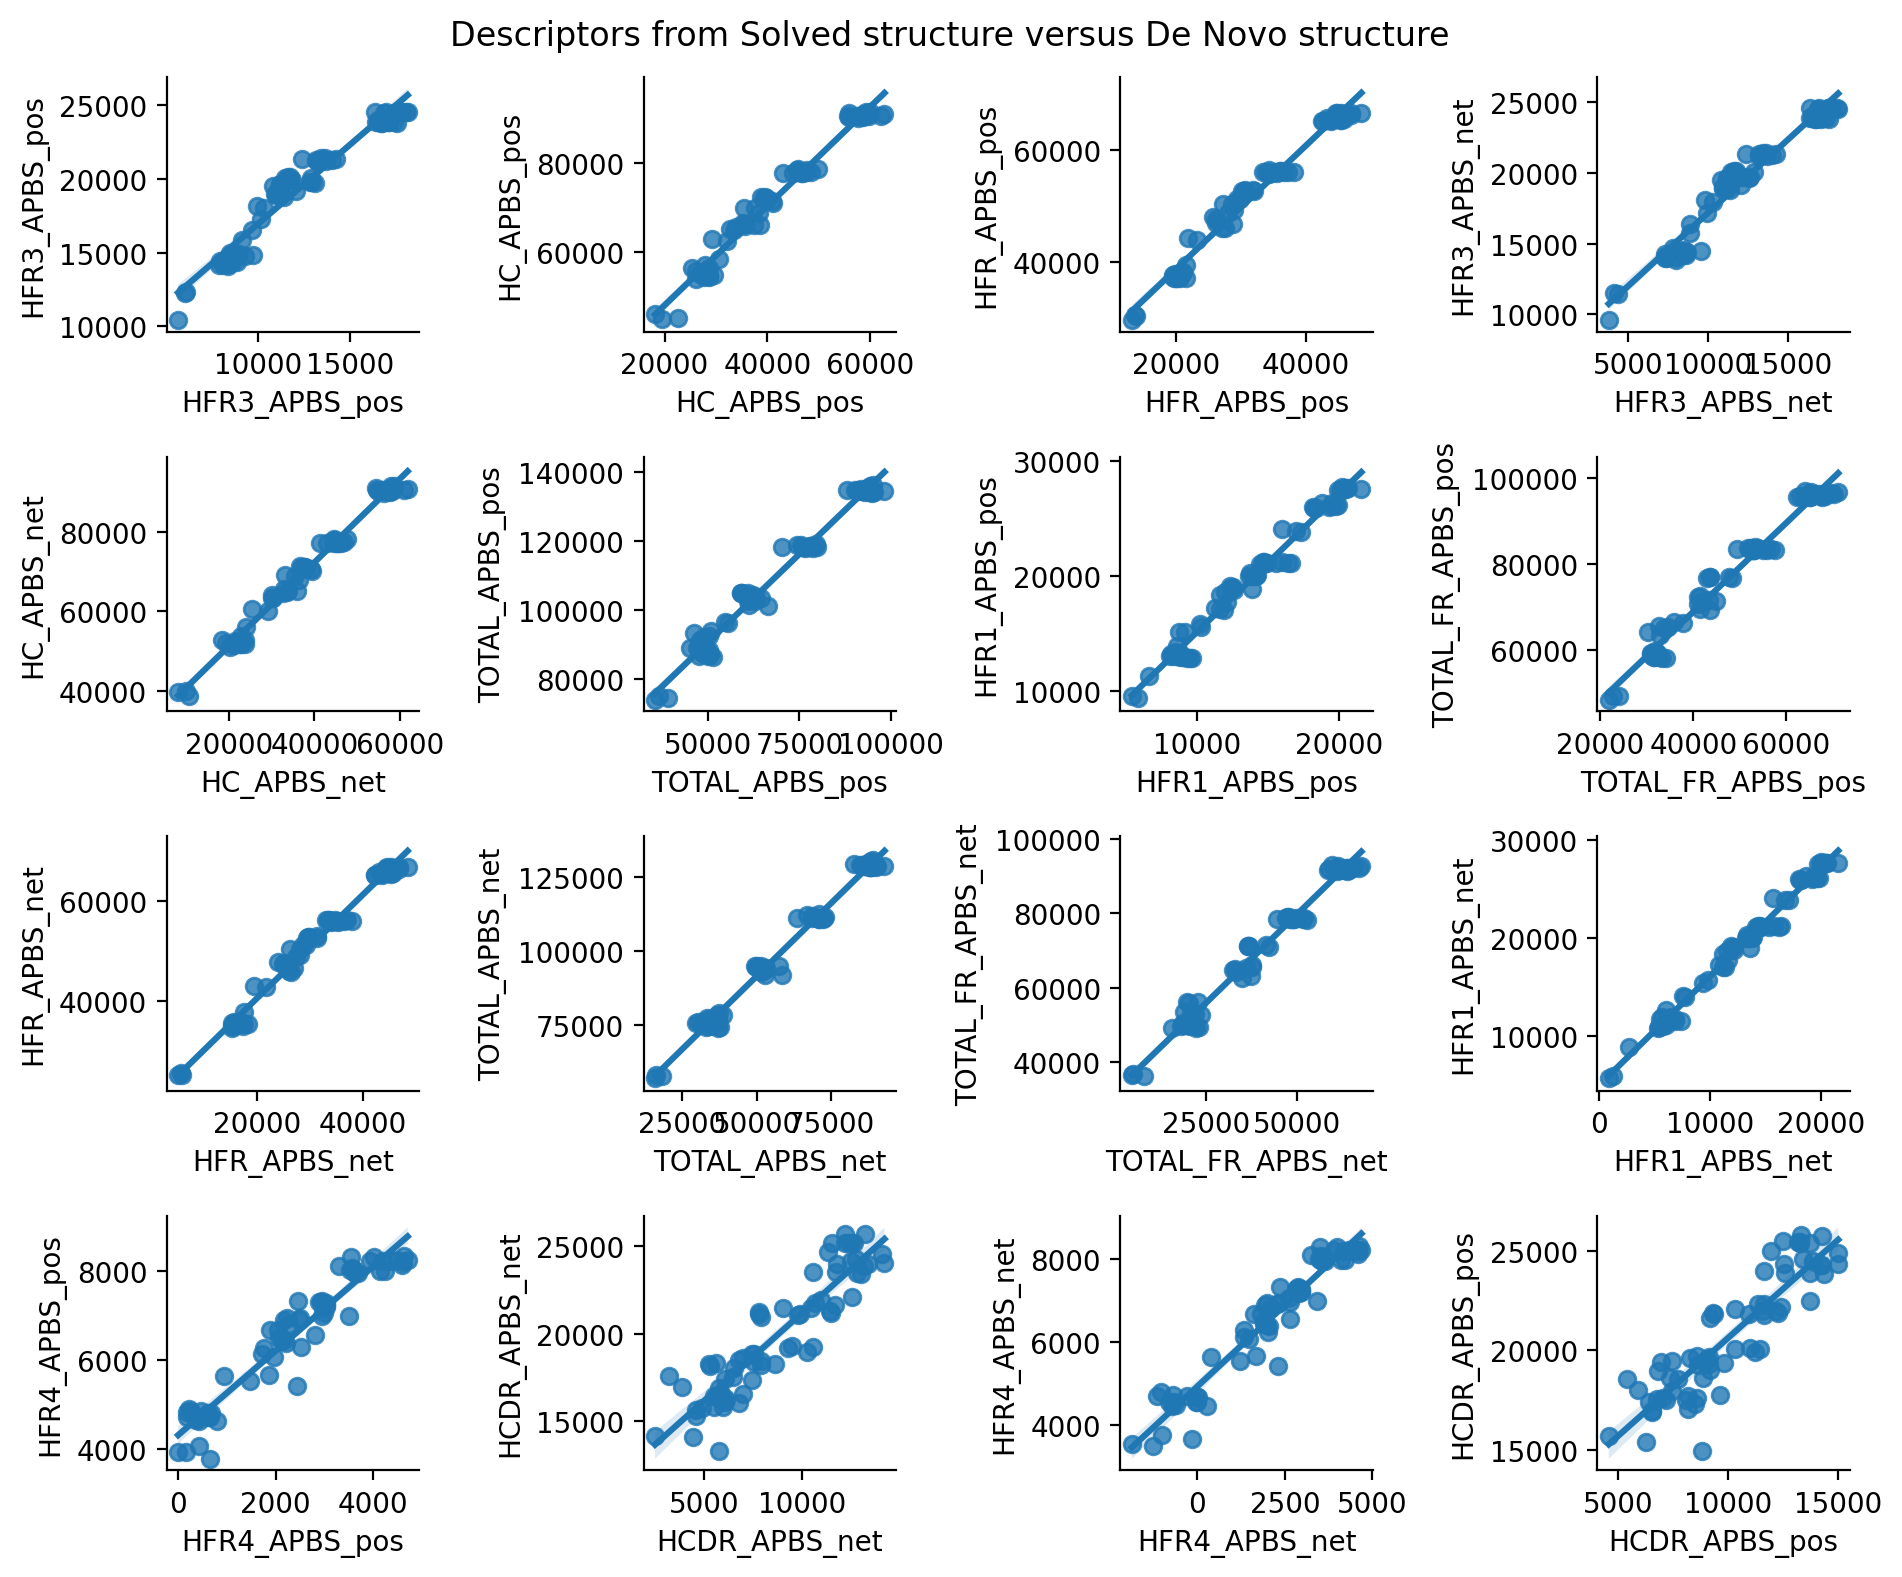

In [10]:
n = 4
height = 2
width = height*1.2

fig, axes = plt.subplots(n,n,figsize =(n*width, n*height))
axes = np.ravel(axes)

cols = heparin_corr.sort_values(ascending = False).index
for i, ax in enumerate(axes): 
    sns.regplot(x = descriptors_df[cols[i]],y = solved_descriptors_df[cols[i]],ax = ax)

sns.despine()
fig.suptitle('Descriptors from Solved structure versus De Novo structure')
plt.tight_layout()

In [11]:
### Remarks: 